<a href="https://colab.research.google.com/github/tom9358/ABVD-python/blob/main/rewrite_to_networkx_language.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
from tqdm import tqdm #progress bars
import matplotlib.pyplot as plt
import networkx as nx
rng = np.random.default_rng() #the internet says this is more proper than using np.random

In [7]:
a=0.1+0.2
a <= 0.3

False

In [8]:
#handy conversion functions that don't do much
def int_to_bool_list(num):
    """converts base-10 number to a list of 1 and 0 (the base-2 representation)"""
    bin_string = format(num, '0'+str(n)+'b')
    return [1 if x=='1' else 0 for x in bin_string]

def list_to_int(data):
    """returns the integer corresponding to a list of booleans"""
    return int(''.join(['1' if i else '0' for i in data]),2)

def state_to_latex(state):
    """turns the array notation (e.g. [[0,1],[1,0]]) into the familiar bunch of ones and zeros with bars on top"""
    string = ''
    for mbit in state.T:
        if mbit[1]: string+='\\widebar{'+str(mbit[0])+'}\,'
        else: string+=str(mbit[0])
    return '$'+string+'$'

def zerotominusone(arr):
    """turns [1,0] into [1,-1]"""
    return [1 if i else -1 for i in arr]

In [9]:
def emptygraph(n, plot=False):
    """generate an empty graph and a dictionary with coordinates for plotting"""
    G = nx.MultiDiGraph()
    pos = {}
    for i in range(2**n):
        for j in range(2**n):
            latexnode = state_to_latex(np.array([int_to_bool_list(i),int_to_bool_list(j)]))
            G.add_node((i,j), reached=False, bits = np.array(int_to_bool_list(i)), bars = np.array(int_to_bool_list(j)), latexnode=latexnode)
            pos.update({(i,j):(i,j)})
    if plot:
        plt.figure(figsize=(15,10), dpi=50)
        nx.draw_networkx(G, pos, node_size=0, font_size=15, font_color='darkgray', labels=nx.get_node_attributes(G,'latexnode'))
        plt.axis("off")
        plt.savefig("empty graph n="+str(n)+".png")
        plt.show()
    return G, pos

In [ ]:
def walktree(state_ind):
    if G.nodes[state_ind]['reached']==True:
        #not sure if this is the right check, as the same state may have different transitions depending on U_current
        return
    pull_ind = pushpull(state_ind, 'pull')
    push_ind = pushpull(state_ind, 'push')
    walktree(pull_ind)
    walktree(push_ind)

def pushpull(state_ind, edgetype):
    node = G.nodes[state_ind]
    node['reached']=True
    bit = np.copy(node['bits'])
    bar = np.copy(node['bars'])
    if edgetype=='push' and not all(bar):
        i = np.where(bar==0, U[1,:,state_ind[0]], np.inf).argmin()
        U_current = U[1,:,state_ind[0]][i]
        bit[i]=(bit[i]+1)%2
    elif edgetype=='pull' and any(bar):
        i = np.where(bar==1, U[0,:,state_ind[0]], -np.inf).argmax()
        U_current = U[0,:,state_ind[0]][i]
    else: return state_ind
    bar[i]=(bar[i]+1)%2
    state_ind_new = (list_to_int(bit),list_to_int(bar))
    via = [state_ind,state_ind_new] #track though which virtual states the transition goes
    state_ind_new, via = checkstable(state_ind_new, bit, bar, U_current, i, via) #check if the new state is stable.
    G.add_edge(state_ind, state_ind_new, direction=edgetype, via=via, transition_length=len(via))
    return state_ind_new

def checkstable(state_ind, bit, bar, U_current, i, via):
    willrelax = np.multiply(U[0,:,state_ind[0]]>U_current, bar==1) #are there any U_r above U_current?
    willsnap  = np.multiply(U[1,:,state_ind[0]]<U_current, bar==0) #are there any U_s below U_current?
    if willrelax[i] or willsnap[i]:
        print("mbit",i,"wants to self loop")
        1/0 #I don't know how to properly stop the code :)
    if sum(willrelax)+sum(willsnap)>1:
        print("multiple mbits want to change state at once")
        1/0
    elif all(~willrelax) and all(~willsnap):#if it's a stable state
        return state_ind, via
    elif sum(willrelax)==0 and sum(willsnap)==1:
        j=np.where(willsnap)
        bit[j]=(bit[j]+1)%2
    elif sum(willrelax)==1 and sum(willsnap)==0:
        j=np.where(willrelax)
    bar[j]=(bar[j]+1)%2
    state_ind_new = (list_to_int(bit),list_to_int(bar))
    via.append(state_ind_new)
    return checkstable(state_ind_new, bit, bar, U_current, j, via)


In [ ]:
n=2
#calculate the switching fields for all states
allbits = np.array([zerotominusone(int_to_bool_list(i)) for i in range(2**n)]).T
#since floats cannot be compared, I decided to just multiply by 100 and use integers. I'm not saying it's a neat solution
u_r = np.array([50,40], ndmin=2).T
u_s = np.array([80,60], ndmin=2).T
u_bare = np.array([u_r, u_s])
C = np.zeros((n,n), dtype=np.int8)
C[0,1] = 0
U = u_bare - np.dot(C, allbits) #reminder: U is [push/pull, mbit, bit configuration]. bars are absent

In [ ]:
G_base, pos = emptygraph(n)#, True
G = G_base.copy()
init_ind = (0,0)

walktree(init_ind)

<Figure size 1350x900 with 0 Axes>

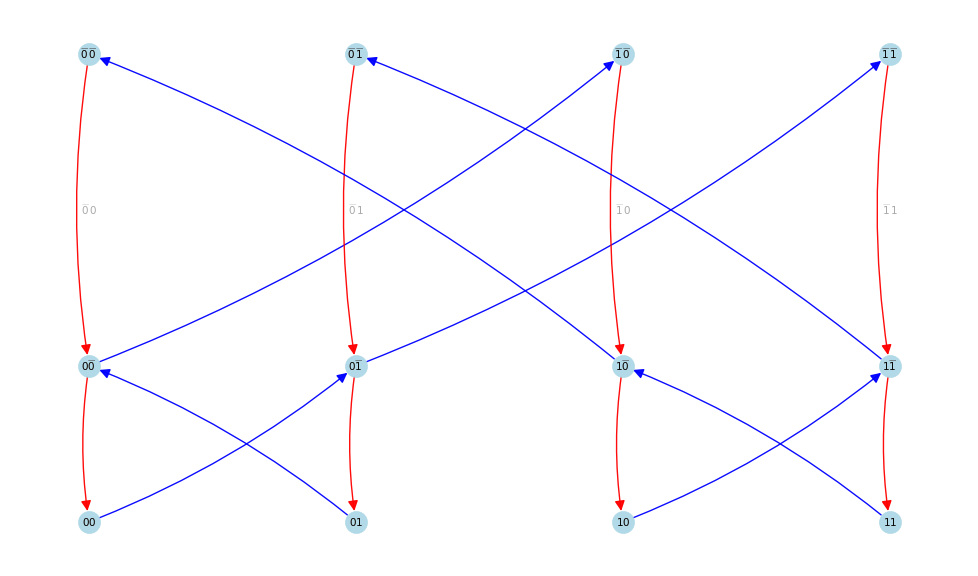

In [ ]:
plt.figure(figsize=(15,10), dpi=90)
G_reached = G.copy()
for x,y in G.nodes(data=True):
    if not y["reached"]: G_reached.remove_node(x)
plt.figure(figsize=(25,15), dpi=50)
nx.draw_networkx(G_base, pos, node_size=0, font_size=15, font_color='darkgray', labels=nx.get_node_attributes(G,'latexnode'))
nx.draw_networkx(G_reached, pos, node_size=1000,
                 font_size=15,
                 font_color='black',
                 labels=nx.get_node_attributes(G_reached,'latexnode'),
                 connectionstyle="arc3,rad=.08",
                 node_color='lightblue',
                 alpha=0.95,
                 arrowsize=30,
                 width=np.array(list(nx.get_edge_attributes(G_reached,'transition_length').values()))**2/2,
                 edge_color=['red' if direction=='pull' else 'blue' for direction in nx.get_edge_attributes(G_reached,'direction').values()])
plt.axis("off")
plt.savefig('n'+str(n)+' r'+str(u_r)+' s'+str(u_s)+' C'+str(C)+".png")
plt.show()

In [ ]:
nx.is_isomorphic(G_old, G_reached)
#isomorphy is too general. graphs G and H are "mechanically isomorphic" if they can be transformed into each other by permuting the mbits. (that's enough right?)

True

In [ ]:
print(C,'\n')
print(u_r.T,'\n')
print(u_s.T)

[[0 0]
 [0 0]] 

[[40 50]] 

[[80 60]]


In [ ]:
#just a readable output of the switching fields, for drawing a graph by hand
for i_state in range(2**n):
    print("state: ",end='')
    for mbit in int_to_bool_list(i_state): print(mbit,end='')
    print()
    for i_pushpull in range(2):
        if i_pushpull: pushpull="push"
        else: pushpull="pull"
        print(pushpull, U[i_pushpull,:,i_state])
    print()

state: 00
pull [40 50]
push [80 60]

state: 01
pull [40 50]
push [80 60]

state: 10
pull [40 50]
push [80 60]

state: 11
pull [40 50]
push [80 60]



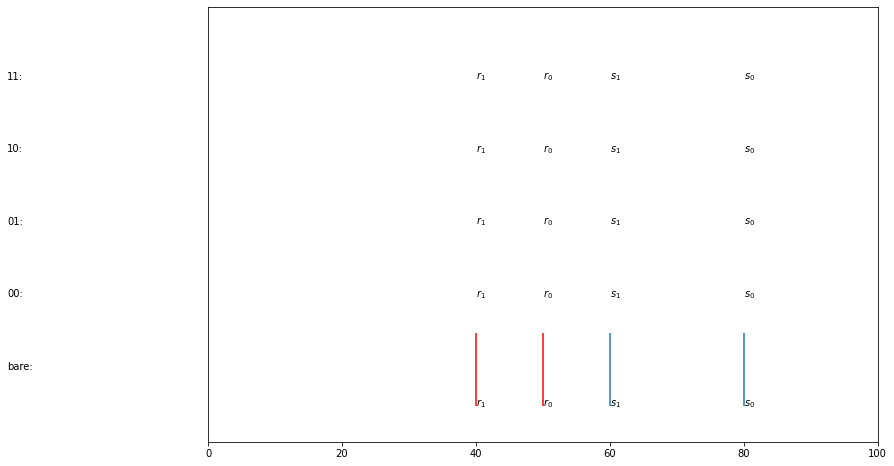

In [ ]:
U_r = U[0]
U_s = U[1]
#visualization of the ordering of the strain thresholds:
plt.figure(figsize=(12,8))#, dpi=50)
for j in range(2**n):
    plt.text(-30,j+2,format(j, '0'+str(n)+'b')+':')
    for i,x in enumerate(U_r.T[j]): plt.text(x,j+2,'$r_'+str(i)+'$')
    for i,x in enumerate(U_s.T[j]): plt.text(x,j+2,'$s_'+str(i)+'$')
plt.gca().get_yaxis().set_visible(False)
plt.xlim([0,U.max()+20])
plt.ylim([0,2**n+2])
plt.eventplot(u_r.T, color='red')
plt.eventplot(u_s.T)
plt.text(-30,1,'bare:')
for i,x in enumerate(u_r): plt.text(x,.5,'$r_'+str(i)+'$')
for i,x in enumerate(u_s): plt.text(x,.5,'$s_'+str(i)+'$')
#plt.axhline(150, linewidth=1)
#plt.show()
plt.savefig("visualization switching fields n="+str(n)+".png")

In [ ]:
#scrap kladblok cell

G, pos = emptygraph(n)
U_current = 0
state_ind = (0,4)
node = G.nodes[state_ind]

edgetype='push'

bit = np.copy(node['bits'])
bar = np.copy(node['bars'])
print(bit,bar)
if edgetype=='push':
    #find which mbit without bar has the smallest U_s that's bigger than U_current #<- this is not true right
    #because here we don't (need to?) consider what the current U is (or should we? het kan..)
    #(treat states with a bar as if their switching field is infinite)
    i = np.where(bar==0, U[1,:,state_ind[0]], np.inf).argmin()
    U_current = U[1,:,state_ind[0]][i]
    #print(np.where(bar==0, U[1,:,state_ind[0]],  np.inf))#debug
    #print(edgetype,i)#debug
    bit[i]=(bit[i]+1)%2
if edgetype=='pull':
    #find which mbit with a bar has the largest U_r that is smaller than U_current
    #(treat states without bar as if the switching field is -infinite)
    i = np.where(bar==1, U[0,:,state_ind[0]], -np.inf).argmax()
    U_current = U[0,:,state_ind[0]][i]
    #print(np.where(bar==1, U[0,:,state_ind[0]],  -np.inf))#debug
    #print(edgetype,i)#debug
bar[i]=(bar[i]+1)%2
print(bit,bar)
state_ind_new = (list_to_int(bit),list_to_int(bar))
print(state_ind_new)
print()
print(checkstable(state_ind_new,bit,bar,U_current,i))

G.add_edge(state_ind, state_ind_new)
node['reached']=True
G.nodes[state_ind_new]['reached']=True
print(node)
print(G.nodes[state_ind_new])

In [ ]:
#not needed anymore I suppose
#every state can be further compressed or relaxed, so a binary tree represents all possible actions that can be taken
class Node:
    def __init__(self, state, strain, parent = None, notnew = False):
        self.parent = parent
        self.push = None
        self.pull = None
        self.state = state
        self.strain = strain
        self.notnew = notnew